In [1]:
import os

import cv2
import mediapipe as mp
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For DL models
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.utils import to_categorical
import time

# For traditional ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
alphabets = list("ABCDEFGHIKLMNOPQRSTUVWXY")
print(alphabets)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [4]:
def augment_image(image):
    augmented_images = [image]  # Start with the original image

    # Rotation augmentation
    for angle in [-15, 15]:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        augmented_images.append(rotated)

    # Brightness variation
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=10)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-10)
    augmented_images.append(bright)
    augmented_images.append(dark)

    # Add slight Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(blurred)

    # Scale variation (zoom in slightly)
    h, w = image.shape[:2]
    zoom_factor = 0.9
    zoomed = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    # Pad to original size
    delta_w = w - zoomed.shape[1]
    delta_h = h - zoomed.shape[0]
    pad_top, pad_bottom = delta_h // 2, delta_h - (delta_h // 2)
    pad_left, pad_right = delta_w // 2, delta_w - (delta_w // 2)
    zoomed_padded = cv2.copyMakeBorder(zoomed, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT)
    augmented_images.append(zoomed_padded)

    return augmented_images

In [5]:
temp_dataset = []

for label in alphabets:
    dataset_directory_prefix = 'SigNN Character Database/'
    for dirname, _, filenames in os.walk(dataset_directory_prefix + label):
        for filename in filenames:
            pathname = os.path.join(dirname, filename)

            with mp_hands.Hands(
                    static_image_mode=True,
                    max_num_hands=1,
                    min_detection_confidence=0.5
            ) as hands:

                original_image = cv2.imread(pathname)
                flipped_image = cv2.flip(original_image, 1)
                augmented_images = augment_image(flipped_image)

                for image in augmented_images:
                    result = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                    vertices = []
                    if not result.multi_hand_landmarks:
                        continue

                    for l in result.multi_hand_landmarks[0].landmark:
                        vertices.append(l.x)
                        vertices.append(l.y)
                        vertices.append(l.z)

                    temp_dataset.append((*vertices, label))

    print(f'import: {label}')

vertices_xyz_label = []
for idx in range(21):
    for char in list('xyz'):
        vertex_label = char + str(idx)
        vertices_xyz_label.append(vertex_label)

dataset = pd.DataFrame(temp_dataset, columns=[*vertices_xyz_label, 'target'])
dataset.head()

In [6]:
# dataset.to_csv('data_augmented.csv', index=False)

In [7]:
dataset = pd.read_csv('data_augmented.csv')

In [8]:
dataset.head()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,x18,y18,z18,x19,y19,z19,x20,y20,z20,target
0,0.537024,0.709137,-1.039713e-06,0.446100,0.664792,-0.028311,0.390810,0.564343,-0.038512,0.370907,...,0.586647,0.513524,-0.073401,0.569946,0.576173,-0.065497,0.561055,0.613263,-0.048136,A
1,0.480497,0.715077,-1.047386e-06,0.405293,0.643013,-0.026713,0.377836,0.534100,-0.039152,0.377684,...,0.580064,0.532452,-0.076533,0.545215,0.588712,-0.066221,0.523055,0.624974,-0.046646,A
2,0.583465,0.687404,-1.044189e-06,0.490636,0.673427,-0.029668,0.411198,0.589470,-0.041000,0.370829,...,0.585183,0.488826,-0.079729,0.585369,0.556547,-0.071089,0.585624,0.597124,-0.052956,A
3,0.535792,0.703311,-9.078552e-07,0.446199,0.660680,-0.023851,0.390639,0.556695,-0.029857,0.368792,...,0.586525,0.510683,-0.064958,0.569589,0.573166,-0.058386,0.560714,0.614685,-0.041671,A
4,0.538493,0.708431,-1.014911e-06,0.445789,0.665042,-0.027627,0.390296,0.563893,-0.037266,0.370523,...,0.585499,0.512222,-0.075066,0.568830,0.575282,-0.067006,0.560402,0.613664,-0.049363,A


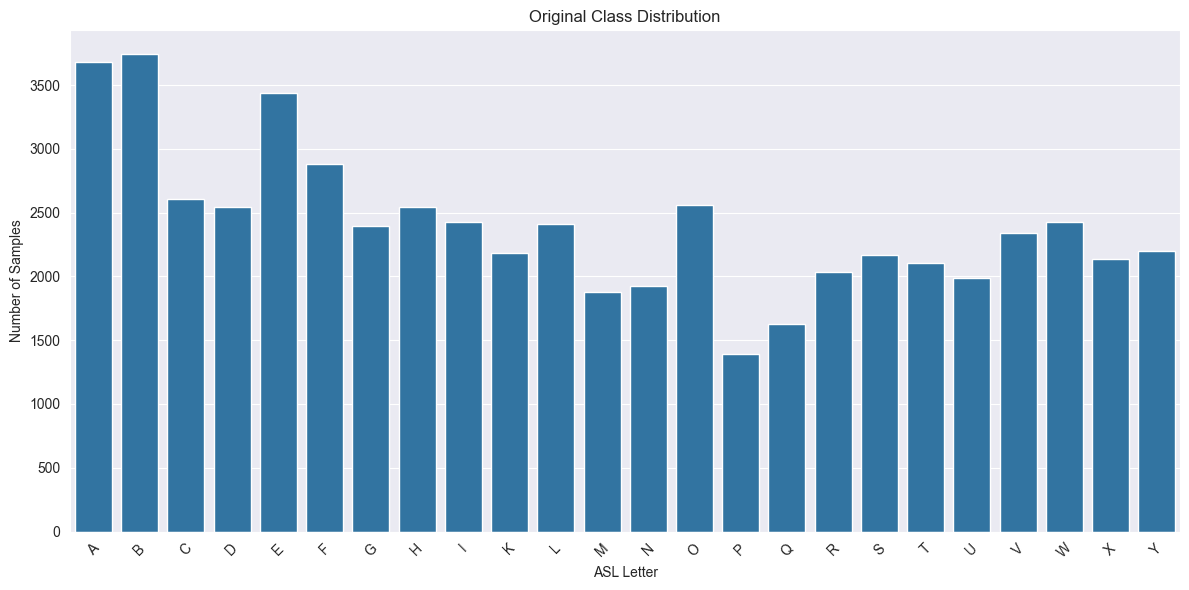

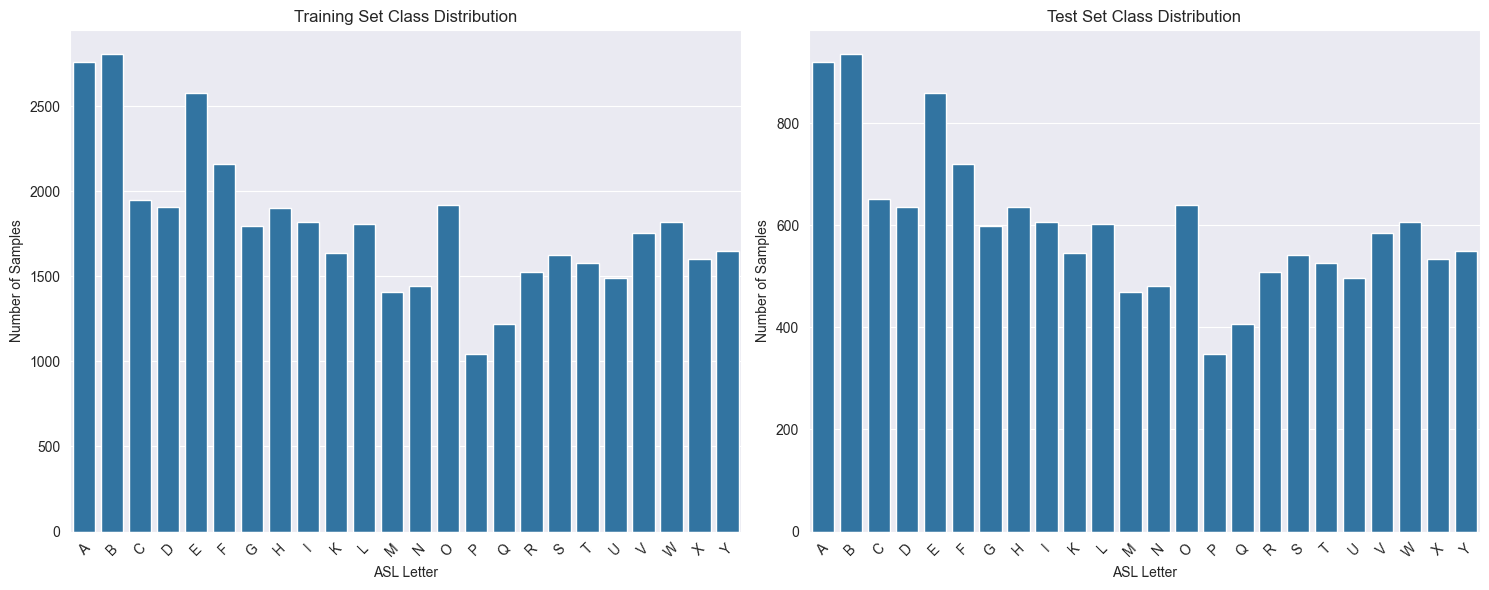

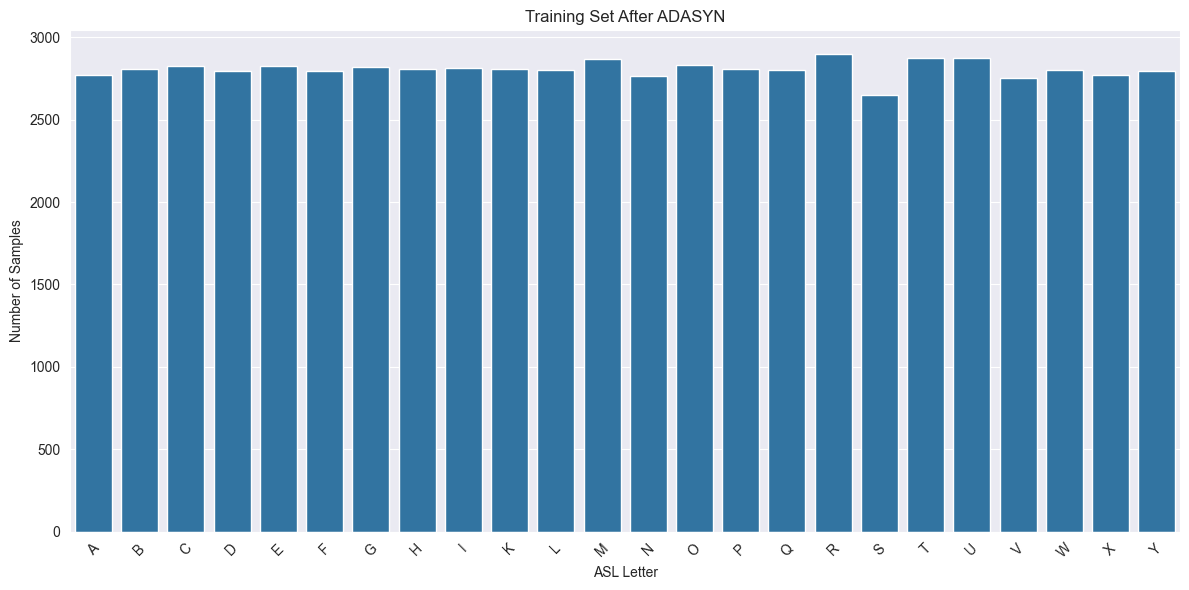

Original dataset shape: (57607, 63)
Original training set shape: (43205, 63)
Resampled training set shape: (67361, 63)
Test set shape: (14402, 63)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

# visualize the original class distribution
plt.figure(figsize=(12, 6))
class_counts = pd.Series(dataset['target']).value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Original Class Distribution')
plt.xlabel('ASL Letter')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Extract features and target
X = dataset.drop(['target'], axis=1).values
y = dataset['target'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y  # Stratify to maintain class distribution
)

# Visualize the train/test distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
train_counts = pd.Series(y_train).value_counts().sort_index()
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.title('Training Set Class Distribution')
plt.xlabel('ASL Letter')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_counts = pd.Series(y_test).value_counts().sort_index()
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.title('Test Set Class Distribution')
plt.xlabel('ASL Letter')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Apply ADASYN only to the training data
adasyn = ADASYN(random_state=42, n_neighbors=8)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Visualize the balanced training data distribution after ADASYN
plt.figure(figsize=(12, 6))
balanced_counts = pd.Series(y_train_resampled).value_counts().sort_index()
sns.barplot(x=balanced_counts.index, y=balanced_counts.values)
plt.title('Training Set After ADASYN')
plt.xlabel('ASL Letter')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print shapes
print(f"Original dataset shape: {X.shape}")
print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Test set shape: {X_test.shape}")

In [10]:
y_train_encoded = pd.get_dummies(y_train, prefix='target')
y_test_encoded = pd.get_dummies(y_test, prefix='target')
y_train_encoded.head(3)

,target_A,target_B,target_C,target_D,target_E,target_F,target_G,target_H,target_I,target_K,...,target_P,target_Q,target_R,target_S,target_T,target_U,target_V,target_W,target_X,target_Y
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

In [12]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# Encode target
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled)
y_test_enc = label_encoder.transform(y_test)

# One‐hot for NN
y_train_oh = to_categorical(y_train_enc)
y_test_oh = to_categorical(y_test_enc)

# Number of classes/features
n_classes = len(np.unique(y_train_resampled))
n_features = X_train_resampled.shape[1]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [14]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True, verbose=1
)


def create_nn_model():
    model = Sequential([
        layers.InputLayer(shape=(n_features,)),
        layers.Dense(n_features), layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'), layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'), layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def train_and_evaluate(model_name, model, X_tr, y_tr, X_te, y_te,
                       is_nn=True, epochs=50, bs=32):
    start = time.time()
    if is_nn:
        hist = model.fit(
            X_tr, y_tr,
            validation_data=(X_te, y_te),
            epochs=epochs, batch_size=bs,
            callbacks=[early_stop], verbose=0
        )
        val_loss = min(hist.history['val_loss'])
        val_acc = max(hist.history['val_accuracy'])
        y_pred = np.argmax(model.predict(X_te), axis=1)
        y_true = np.argmax(y_te, axis=1)
    else:
        hist = None
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        y_true = y_te
        val_acc = accuracy_score(y_true, y_pred)
        val_loss = None

    train_time = time.time() - start
    eval_start = time.time()
    _ = model.predict(X_te)
    eval_time = time.time() - eval_start

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_, output_dict=True
    )

    print(len(X_te))

    return {
        'model_name': model_name, 'val_loss': val_loss,
        'val_accuracy': val_acc, 'training_time': train_time,
        'evaluation_time': eval_time,
        'eval_time_per_sample': eval_time / len(X_te),
        'confusion_matrix': cm, 'classification_report': report,
        'model': model, 'history': hist
    }

In [17]:
results = []

# 1. Simple NN
nn = create_nn_model()
results.append(train_and_evaluate(
    'Neural Network', nn,
    X_train_scaled, y_train_oh,
    X_test_scaled, y_test_oh,
    is_nn=True
))

# 2. Random Forest
rf = RandomForestClassifier(100, random_state=42, n_jobs=-1)
results.append(train_and_evaluate(
    'Random Forest', rf,
    X_train_scaled, y_train_enc,
    X_test_scaled, y_test_enc,
    is_nn=False
))

# 3. KNN
knn = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)
results.append(train_and_evaluate(
    'KNN', knn,
    X_train_scaled, y_train_enc,
    X_test_scaled, y_test_enc,
    is_nn=False
))


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
14402
14402
14402


In [18]:
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['val_accuracy'],
        'Training Time (s)': r['training_time'],
        'Evaluation Time (s)': r['evaluation_time'],
        'Eval Time Per Sample (ms)': r['eval_time_per_sample'] * 1000,
        'F1‐Score (macro)': r['classification_report']['macro avg']['f1-score']
    }
    for r in results
])

C:\Users\brill\AppData\Local\Temp\ipykernel_77020\942120014.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis', ax=axes[0, 0])
C:\Users\brill\AppData\Local\Temp\ipykernel_77020\942120014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1‐Score (macro)', data=results_df, palette='viridis', ax=axes[0, 1])
C:\Users\brill\AppData\Local\Temp\ipykernel_77020\942120014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=results_df

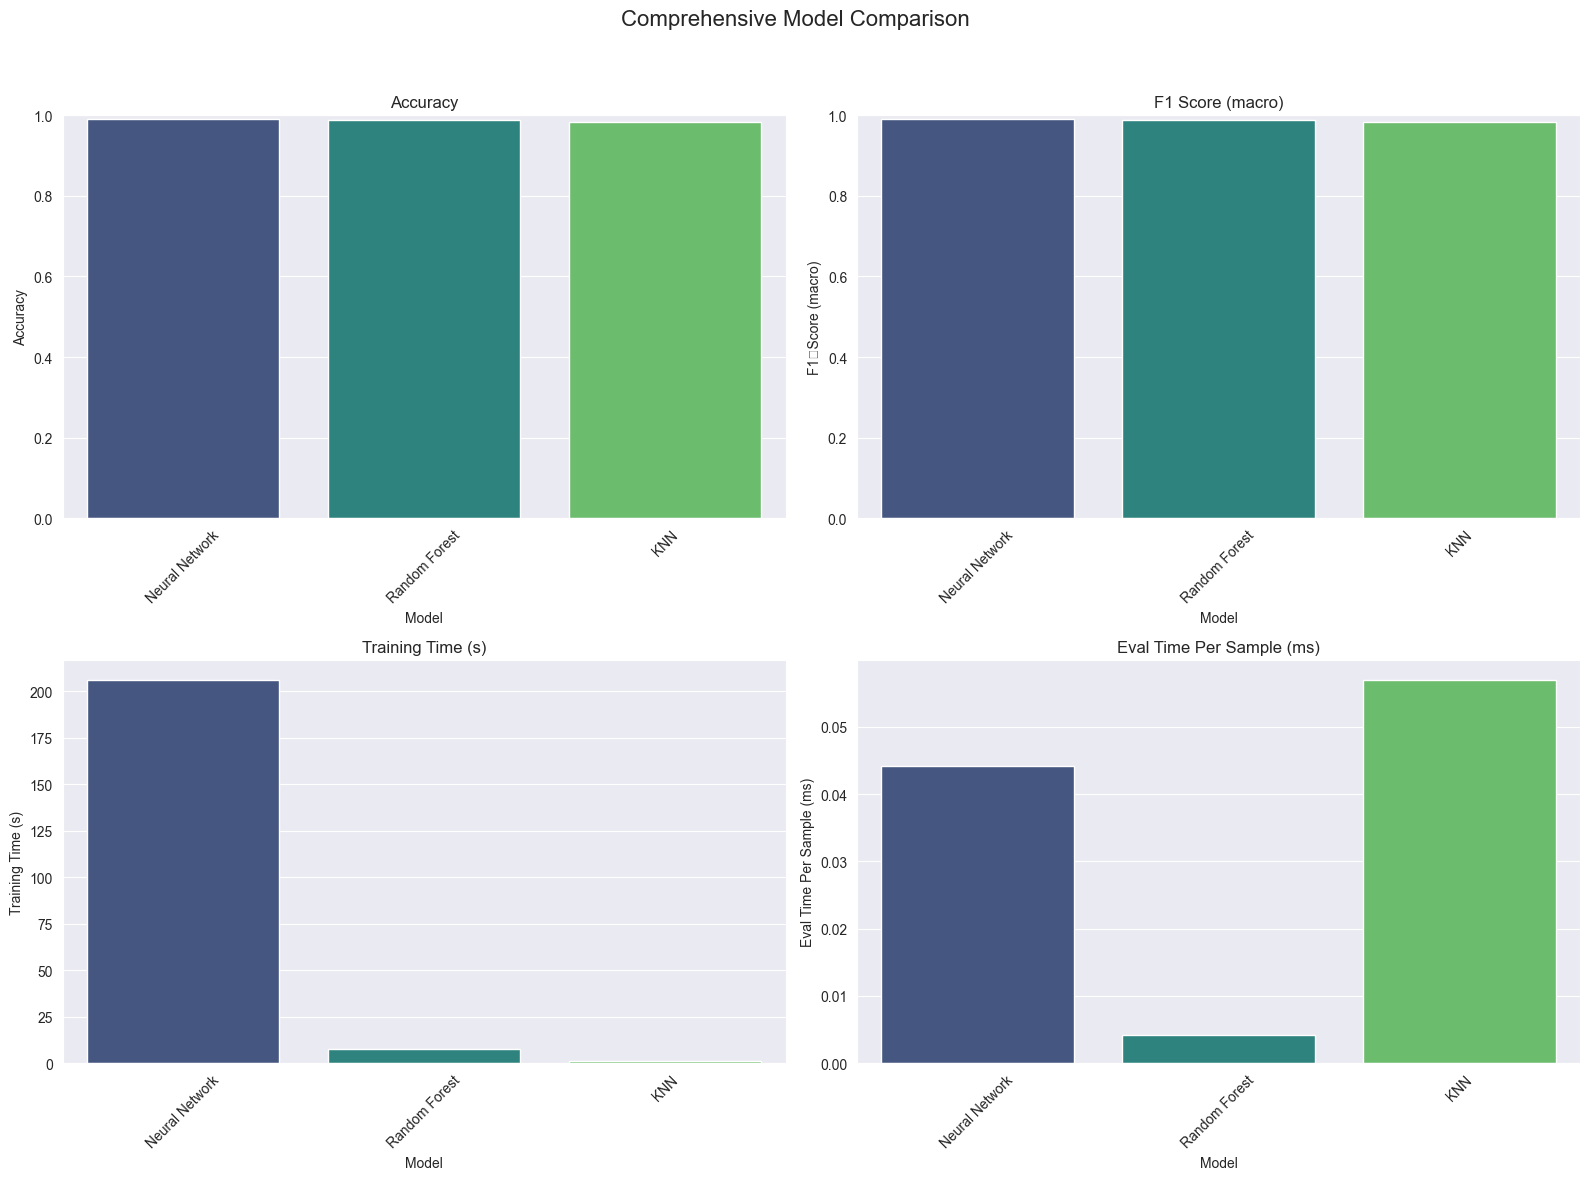

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# F1‐Score
sns.barplot(x='Model', y='F1‐Score (macro)', data=results_df, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('F1 Score (macro)')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

# Training Time
sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Training Time (s)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Eval Time per Sample
sns.barplot(x='Model', y='Eval Time Per Sample (ms)', data=results_df, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Eval Time Per Sample (ms)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Comprehensive Model Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


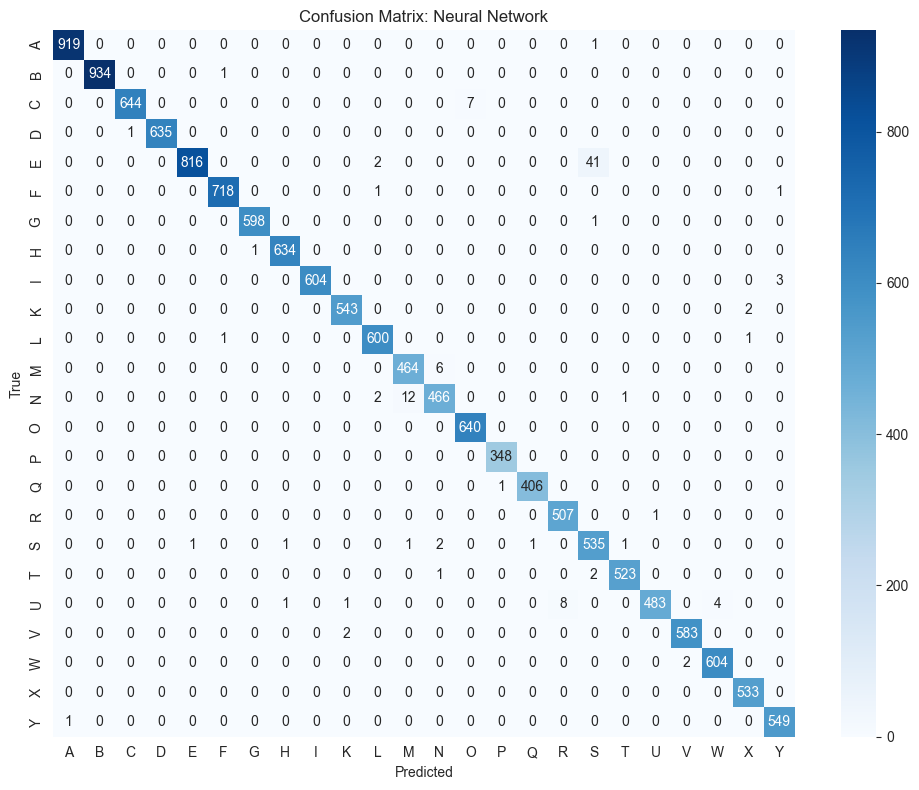

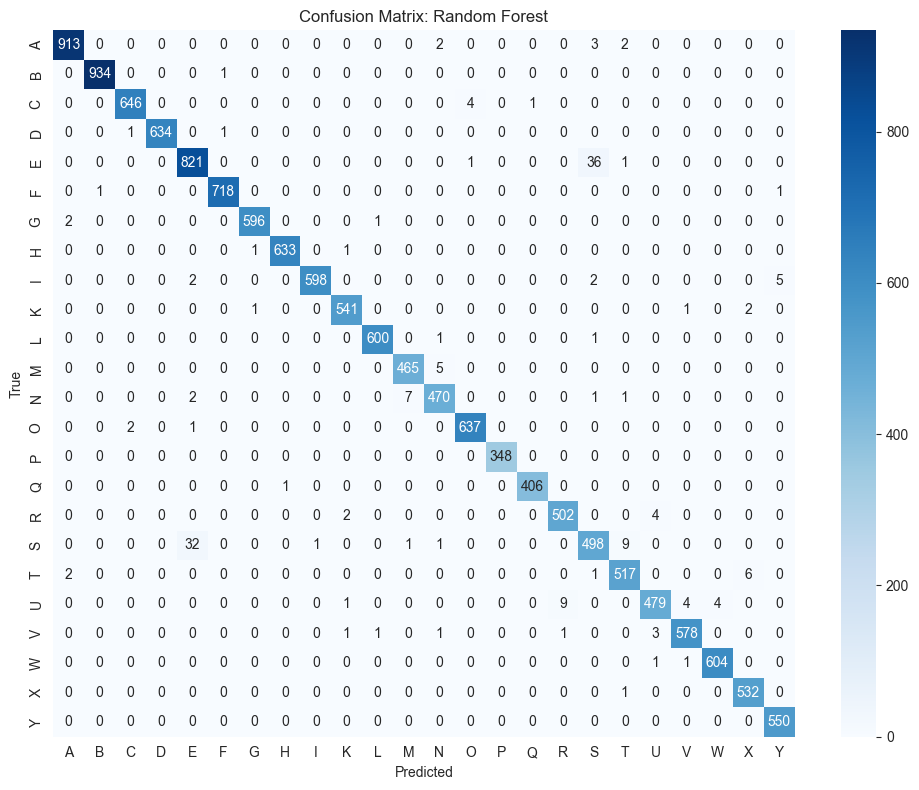

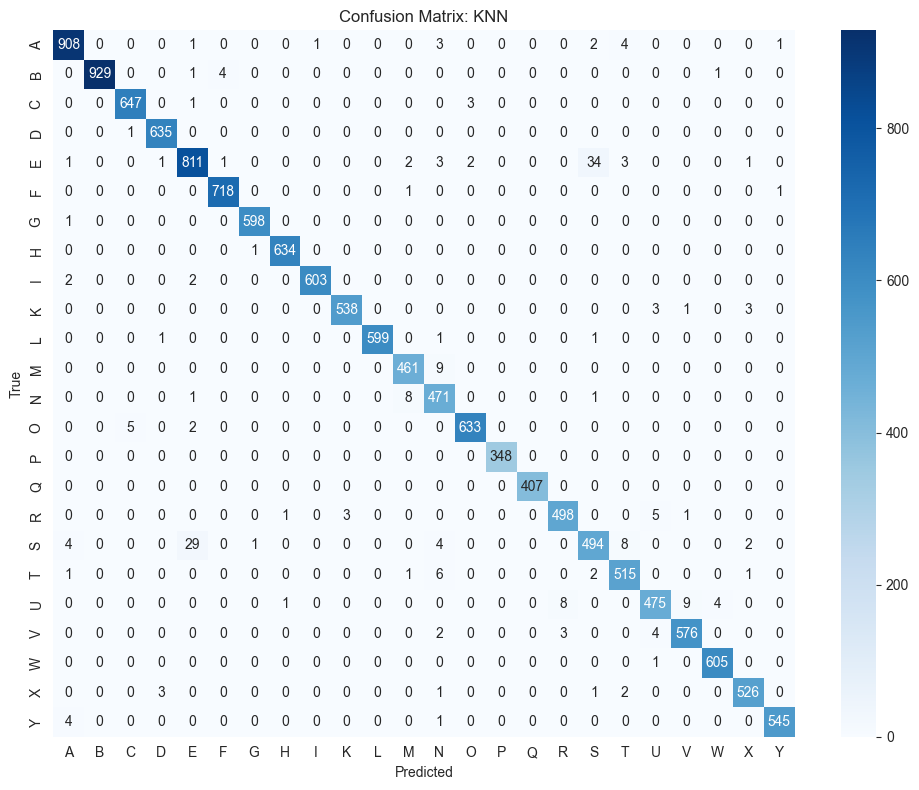

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

for r in results:
    cm = r['confusion_matrix']
    model_name = r['model_name']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
